In [ ]:
# pip install gradio==3.39.0

In [34]:
from langchain.prompts import PromptTemplate
from langchain.llms.openai import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langchain.text_splitter import CharacterTextSplitter, SpacyTextSplitter, NLTKTextSplitter
from langchain.graphs.networkx_graph import KG_TRIPLE_DELIMITER
from pprint import pprint
from pyvis.network import Network
import networkx as nx
import gradio as gr

import nltk
nltk.download('punkt')

/Users/aidausmanova/Desktop/climatenlp/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/aidausmanova/Desktop/climatenlp/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aidausmanova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import platform
platform.machine()

'arm64'

In [3]:
platform.version()

'Darwin Kernel Version 23.4.0: Fri Mar 15 00:12:25 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T6030'

#### Chunking

In [42]:
report_files = [
        "Airbus_SE-Document_d_Enregistrement_Universel-EN",
        "ArcelorMittal_SA-SASB_Index-EN",
        "Assicurazioni_Generali_SpA-SASB_Index-EN",
        "Banco_Santander_SA-Annual_Report-EN",
        "Bayer_AG-2021_Sustainability_Report-EN",
        "Deutsche_Bank_AG-Non-EN",
        "Deutsche_Lufthansa_AG-SASB_Report-EN",
        "Deutsche_Wohnen-2020_Sustainability_Report-EN",
        "Enel_SpA-Sustainability_Report-EN",
        "Eni_SpA-Sustainability_Report-EN",
        "Poste_Italiane-2017_Sustainability_Report-EN",
        "Telecom_Italia_SpA-Corporate_Responsibility_Reports-EN",
        "TotalEnergies-Universal_Registration_Document-EN",
        "Uniper_SE-2021_Sustainability_Report-EN"
    ]

In [43]:
docs_lens = []

for report_file in report_files:
    with open("../data/"+report_file+".txt", 'r') as f:
        report = f.read().replace('\n', '')
    text_splitter = NLTKTextSplitter()
    docs = text_splitter.split_text(report)
    docs_lens.append(len(docs))

Created a chunk of size 4656, which is longer than the specified 4000


In [45]:
docs_lens

[257, 8, 2, 764, 137, 141, 3, 99, 379, 60, 146, 198, 612, 73]

In [4]:
text_splitter = NLTKTextSplitter()
docs = text_splitter.split_text(report)
len(docs)

764

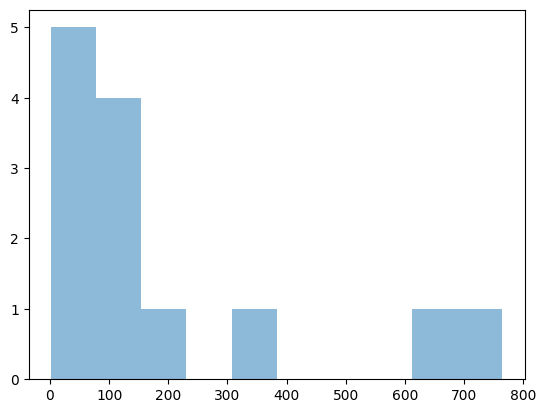

In [10]:
import numpy as np
from matplotlib import pyplot as plt

# Lengths of sustainability reports
plt.hist(docs_lens, alpha=0.5)
plt.show()

In [29]:

file = "Airbus_SE-Document_d_Enregistrement_Universel-EN.json"
with open("../results/raw/"+file, 'r') as f:
    raw = f.read().replace('\n', '')

data = json.loads(raw)

In [13]:
ts_sentences = {
        "Impact": [],
        "Risks": [],
        "Opportunities": [],
        "Strategy": [],
        "Actions": [],
        "Targets": [],
        "Organization": [],
        "Reporting": [],
        "Reporting_date": []
        }

for c in data:
    if c['subject'] == "Impact" and c['object'] != "N/A":
        ts_sentences['Impact'].extend(c['object'].strip().split('\n'))
    if c['subject'] == "Risks" and c['object'] != "N/A":
        ts_sentences['Risks'].extend(c['object'].strip().split('\n'))
    if c['subject'] == "Opportunities" and c['object'] != "N/A":
        ts_sentences['Opportunities'].extend(c['object'].strip().split('\n'))
    if c['subject'] == "Strategy" and c['predicate'] == 'hasDescription' and c['object'] != "N/A":
        ts_sentences['Strategy'].extend(c['object'].strip().split('\n'))
    if c['subject'] == "Actions" and c['object'] != "N/A":
        ts_sentences['Actions'].extend(c['object'].strip().split('\n'))
    if c['subject'] == "Targets" and c['object'] != "N/A":
        ts_sentences['Targets'].extend(c['object'].strip().split('\n'))

org, report, report_date = [], [], []
for c in data:
    if c['object'] != "N/A":
        if c['subject'] == "Organization":
            print(c['object'])
            org.append(c['object'])
        if c['subject'] == "Reporting" and c['predicate'] == "hasName":
            report.append(c['object'])
        if c['subject'] == "Reporting" and c['predicate'] == "releaseDate":
            report_date.append(c['object'])

In [51]:
# Select most common extracted report name
def most_common(lst):
    return max(set(lst), key=lst.count)

com = most_common(report)
com

'Airbus Registration Document 2021'

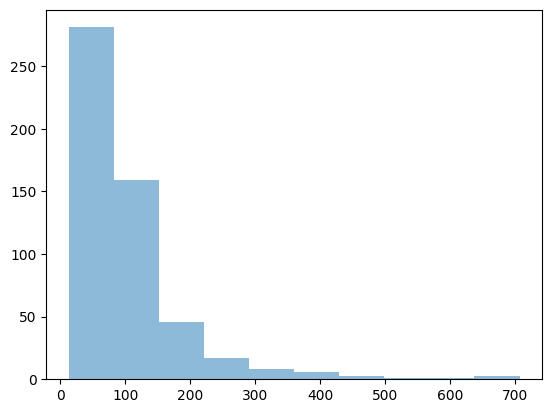

In [21]:
import numpy as np
from matplotlib import pyplot as plt

lens = []
for s in ts_sentences['Actions']:
    lens.append(len(s))

plt.hist(lens, alpha=0.5)
plt.show()

### Extract triples

In [47]:
import os
import openai
import json

prompt_file = "ontosustain_stso_2.json"
# prompt_file = "ontosustain_siso.json"
# prompt_file = "ontosustain_srso.json"
with open('models/prompt/'+prompt_file) as f: 
    dict = json.load(f)
prompt = dict['prompt']

file = "Deutsche_Bank_AG-Non-EN.txt"
with open("../data/"+file, 'r') as f:
    report = f.read().replace('\n', '')

In [49]:
openai.api_key = ('OPENAI_KEY')

KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT = PromptTemplate(
    input_variables=["text"],
    template=prompt,
)

# Initialize chain
# GPT 4: 8,192 tokens
llm = ChatOpenAI(
    api_key=openai.api_key,
    temperature=0.9,
    model="gpt-4"
    )

# Create an LLMChain using the knowledge triple extraction prompt
chain = LLMChain(llm=llm, prompt=KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT)

/Users/aidausmanova/Desktop/climatenlp/venv/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [50]:
def parse_triples(response, delimiter=KG_TRIPLE_DELIMITER):
    if not response:
        return []
    return response.split(delimiter)

In [51]:
# Carbontracker to get energy usage and estimate emissions
from carbontracker import parser
parser.print_aggregate(log_dir="../logs/")

The training of models in this work is estimated to use 0.000 kWh of electricity contributing to 0.000 kg of CO2eq. Measured by carbontracker (https://github.com/lfwa/carbontracker).


In [ ]:
from tqdm import tqdm
from carbontracker.tracker import CarbonTracker
# Run the chain with the specified text
# test_text = "CO2 emissions are to be reduced by 55 percent by 2030 and Hamburg is to become climate-neutral by 2050. The climate plan describes responsibilities and the respective CO2 reduction targets in the sectors 'transport', 'private households', 'trade and services' and 'industry'"

# triples = chain.invoke(
#     {'text' : report}
# ).get('text')


all_triples = []
tracker = CarbonTracker(epochs=764, log_dir="../logs/")

for doc in tqdm(docs[:1]):
    tracker.epoch_start()
    triples = chain.invoke(
        {'text' : doc}
    ).get('text')

    triples_data = parse_triples(triples)
    triples_list = triples_data[0].strip().split('|')
    triples_list_clean = list(filter(lambda x,m=max(map(len, triples_list)):len(x)>0, triples_list))
    all_triples.extend(triples_list_clean)
    tracker.epoch_end()
    # pprint(triples_list_clean)

tracker.stop()

logs = parser.parse_all_logs(log_dir="./logs/")

In [141]:
triplets_json = []
for triplet in all_triples:
    # print(triplet)
    split = triplet.strip().split('~')
    if len(split) == 3:
        subject, predicate, obj = triplet.strip().split('~')
        triplets_json.append(
            {"subject": subject.strip(), "object": obj.strip(), "predicate": predicate.strip(), }
        )

In [142]:
# Save triples to JSON
raw_json_path = "../results/raw/"+file[:-4]+".json"
with open(raw_json_path, 'w', encoding='utf-8') as f:
    json.dump(triplets_json, f, ensure_ascii=False, indent=4)

#### Summarize JSON output

In [112]:
file = "Deutsche_Bank_AG-Non-EN.txt"
raw_json_path = "../results/raw/"+file[:-4]+".json"
with open(raw_json_path, 'r') as f:
    content = json.load(f)

processed_triples_dict = content[:11]

In [113]:
import pandas as pd
import numpy as np

ts_sentences = {
    "Impact": [],
    "Risks": [],
    "Opportunities": [],
    "Strategy": [],
    "Actions": [],
    "AdoptedPolicies": [],
    "Targets": []
}

for c in content:
    if c['subject'] == "Impact":
        ts_sentences['Impact'].extend(c['object'].strip().split('\n'))
    if c['subject'] == "Risks":
        ts_sentences['Risks'].extend(c['object'].strip().split('\n'))
    if c['subject'] == "Opportunities":
        ts_sentences['Opportunities'].extend(c['object'].strip().split('\n'))
    if c['subject'] == "Strategy" and c['predicate'] == 'hasDescription':
        ts_sentences['Strategy'].extend(c['object'].strip().split('\n'))
    if c['subject'] == "Actions":
        ts_sentences['Actions'].extend(c['object'].strip().split('\n'))
    if c['subject'] == "AdoptedPolicies":
        ts_sentences['AdoptedPolicies'].extend(c['object'].strip().split('\n'))
    if c['subject'] == "Targets":
        ts_sentences['Targets'].extend(c['object'].strip().split('\n'))

In [114]:
# Per aspect summarization
N_SENTENCES = 5
start_prompt = "Given list of sentences. "
ts_prompts = {
    "Impact": f"Summurise company's negative impact on the environment in {N_SENTENCES} sentences.",
    "Risks": f"Summurise material risks from company's impact on environment in {N_SENTENCES} sentences.",
    "Opportunities": f"Summurise financial materiality and the effect of climate change on the company in {N_SENTENCES} sentences.",
    "Strategy": f"Summurise company's past and current efforts to mitigate negative environmental impact in {N_SENTENCES} sentences.",
    "Actions": f"Summurise concrete actions taken by company to mitigate negative environmental impact in {N_SENTENCES} sentences.",
    "AdoptedPolicies": f"Summurise company's adopted policies towards sustainable economy in {N_SENTENCES} sentences.",
    "Targets": f"Summurise company's goals towards sustainable economy in {N_SENTENCES} sentences."
}
end_prompt = "Add line breaks between output sentences. \n Sentences: {text}"

In [115]:
out_ts = {
    "Impact": "",
    "Risks": "",
    "Opportunities": "",
    "Strategy": "",
    "Actions": "",
    "AdoptedPolicies": "",
    "Targets": ""
}

for aspect in tqdm(ts_prompts.keys()):
    template_prompt = PromptTemplate(
        input_variables=["text"], template=start_prompt+ts_prompts[aspect]+end_prompt
    )
    # final_prompt = template_prompt.format(standard=ts_prompts['impact'] )
    chain = LLMChain(llm=llm, prompt=template_prompt)

    out = chain.invoke(
        {'text' : '.'.join(ts_sentences[aspect])}
    ).get('text')

    out_ts[aspect] = out

100%|██████████| 7/7 [01:11<00:00, 10.29s/it]


In [116]:
for aspect in out_ts.keys():
    processed_triples_dict.append(
        {
            "subject": aspect,
            "object": out_ts[aspect],
            "predicate": "hasDescription"
        }
    )

In [128]:
# Save triples to JSON
processed_json_path = "../results/processed/"+file[:-4]+".json"
with open(processed_json_path, 'w', encoding='utf-8') as f:
    json.dump(processed_triples_dict, f, ensure_ascii=False, indent=4)

### Visualise KG

In [29]:
import json

def read_json(path):
    with open(path, 'r') as f:
        content = json.load(f)
    return content

def create_graph_from_triplets(triplets_dict):
    G = nx.DiGraph()
    # for triplet in triplets:
    #     subject, predicate, obj = triplet.strip().split('~')
    #     G.add_edge(subject.strip(), obj.strip(), label=predicate.strip())
    # for triplet in triplets:
    #     subject, predicate, obj = triplet.strip().split('|')
    for item in triplets_dict:
        G.add_edge(item['subject'], item['object'], label=item['predicate'])
        
    return G

def nx_to_pyvis(networkx_graph):
    pyvis_graph = Network(notebook=True, cdn_resources='remote')
    for node in networkx_graph.nodes():
        pyvis_graph.add_node(node)
    for edge in networkx_graph.edges(data=True):
        pyvis_graph.add_edge(edge[0], edge[1], label=edge[2]["label"])
    return pyvis_graph

def generateGraph(triplets_json):
    triples_dict = read_json("../results/processed/Airbus_SE-Document_d_Enregistrement_Universel-EN.json")
    # triplets = [t.strip() for t in triples_list_clean if t.strip()]
    graph = create_graph_from_triplets(triples_dict)
    pyvis_network = nx_to_pyvis(graph)

    pyvis_network.toggle_hide_edges_on_drag(True)
    pyvis_network.toggle_physics(False)
    pyvis_network.set_edge_smooth('discrete')

    html = pyvis_network.generate_html()
    html = html.replace("'", "\"")

    return f"""<iframe style="width: 100%; height: 600px;margin:0 auto" name="result" allow="midi; geolocation; microphone; camera;
    display-capture; encrypted-media;" sandbox="allow-modals allow-forms
    allow-scripts allow-same-origin allow-popups
    allow-top-navigation-by-user-activation allow-downloads" allowfullscreen=""
    allowpaymentrequest="" frameborder="0" srcdoc='{html}'></iframe>"""

In [ ]:
# KG example

demo = gr.Interface(
    generateGraph,
    inputs=None,
    outputs=gr.outputs.HTML(),
    title="Knowledge Graph",
    allow_flagging='never',
    live=True,
)

demo.launch(
    height=800,
    width="100%"
)

### Annotations analysis

In [2]:
from nltk import agreement
import pandas as pd
import numpy as np

annotatin_df = pd.read_csv("../data/annotations_4.csv")
annotatin_df.shape

(84, 8)

In [3]:
annotatin_df.head()

,organization,aspect,tm_annotator_1,tm_annotator_2,tm_annotator_3,vague_annotator_1,vague_annotator_2,vague_annotator_3
0,airbus,strategy,1,1,1,0,1,0
1,airbus,impact,0,0,0,0,0,0
2,airbus,risks,1,1,1,0,1,0
3,airbus,opportunities,1,1,1,1,1,0
4,airbus,actions,1,0,0,0,0,0


In [5]:
groupped = annotatin_df.groupby("aspect").sum().reset_index()
groupped['tm_total']= groupped[["tm_annotator_1", "tm_annotator_2", "tm_annotator_3"]].sum(axis=1)
groupped['vague_total']= groupped[["vague_annotator_1", "vague_annotator_2", "vague_annotator_3"]].sum(axis=1)
groupped

,aspect,tm_annotator_1,tm_annotator_2,tm_annotator_3,vague_annotator_1,vague_annotator_2,vague_annotator_3,tm_total,vague_total
0,actions,14,13,11,2,1,3,38,6
1,impact,9,11,9,5,3,1,29,9
2,opportunities,8,12,11,5,3,2,31,10
3,risks,12,14,14,1,1,0,40,2
4,strategy,13,13,14,3,2,1,40,6
5,targets,12,14,13,3,4,6,39,13


In [16]:
show_df = pd.DataFrame()
show_df['aspect'] = groupped['aspect']
show_df['tm_total'] = groupped[["tm_annotator_1", "tm_annotator_2"]].sum(axis=1)
show_df['vague_total'] = groupped[["vague_annotator_1", "vague_annotator_2"]].sum(axis=1)
show_df

,aspect,tm_total,vague_total
0,actions,27,3
1,impact,20,8
2,opportunities,20,8
3,risks,26,2
4,strategy,26,5
5,targets,26,7


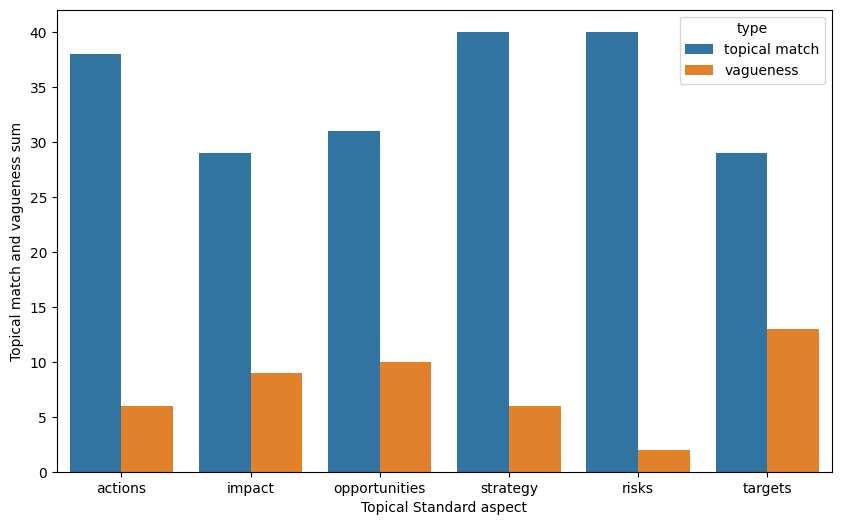

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=show_df, x='aspect', y='value', hue='type')
# plt.title('Distribution of Median Housing Prices in Boston')
plt.xlabel('Topical Standard aspect')
plt.ylabel('Topical match and vagueness sum')
# plt.grid(True)
plt.show()

AttributeError: module 'seaborn' has no attribute 'plt'

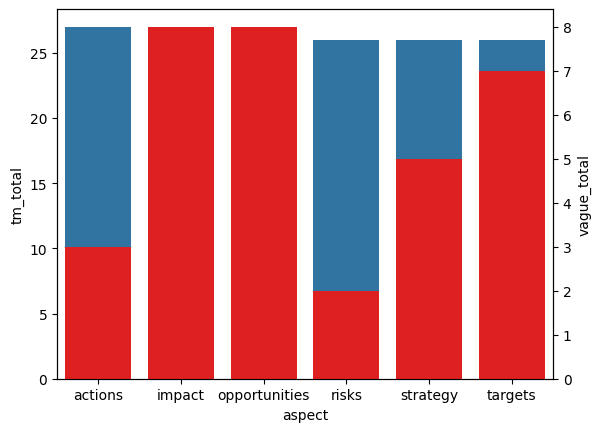

In [27]:
fig, ax = plt.subplots()
sns.barplot(data=show_df, x='aspect', y='tm_total', ax=ax)
ax2 = ax.twinx()
sns.barplot(data=show_df, x='aspect', y='vague_total', ax=ax2, color='r')
sns.plt.show()

In [9]:
def calculate_iaa(rater1, rater2, rater3):
    taskdata=[[0,str(i),str(rater1[i])] for i in range(0,len(rater1))]+[[1,str(i),str(rater2[i])] for i in range(0,len(rater2))]+[[2,str(i),str(rater3[i])] for i in range(0,len(rater3))]
    ratingtask = agreement.AnnotationTask(data=taskdata)
    print("kappa " +str(ratingtask.kappa()))
    print("fleiss " + str(ratingtask.multi_kappa()))
    print("alpha " +str(ratingtask.alpha()))
    print("scotts " + str(ratingtask.pi()))

In [10]:
calculate_iaa(annotatin_df['tm_annotator_1'].to_list(), annotatin_df['tm_annotator_2'].to_list(), annotatin_df['tm_annotator_3'].to_list())

kappa 0.5116855218696835
fleiss 0.5062695924764891
alpha 0.5042791310072416
scotts 0.5023041474654376


In [16]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from statsmodels.stats import inter_rater as irr

cohen_kappa_score(annotatin_df['tm_annotator_1'].to_list(), annotatin_df['tm_annotator_2'].to_list())

0.4590163934426229

In [17]:
confusion_matrix(annotatin_df['tm_annotator_1'].to_list(), annotatin_df['tm_annotator_2'].to_list())

array([[ 6, 10],
       [ 1, 67]])

In [21]:
arr = np.column_stack((annotatin_df['tm_annotator_1'].to_list(), annotatin_df['tm_annotator_2'].to_list()))
agg = irr.aggregate_raters(arr)
irr.fleiss_kappa(agg[0], method='fleiss')

0.4458770614692655